NAMED ENTITY RECOGNITION

1. Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.shape

(1048575, 6)

2. Extract mappings required for the neural network

In [ ]:
#function to extract 2 dictionaries from the dataset (converts into a set to get unique elements)- 
# 1) maps word/tsg to index : eg: thousand:2
# 2) maps index to a word/tag: eg: 2:thousand

from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
#maps the indices to the word or tag
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,28800,11
1,NaN,of,IN,O,22487,11
2,NaN,demonstrators,NNS,O,9537,11
3,NaN,have,VBP,O,17442,11
4,NaN,marched,VBN,O,32696,11


3. Transform columns to extract sequential data

In [ ]:
# Fill na
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

<ipython-input-6-04716ffa74c4>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data_fillna.groupby(


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[28800, 22487, 9537, 17442, 32696, 21409, 311,...","[11, 11, 11, 11, 11, 11, 3, 11, 11, 11, 11, 11..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[32153, 34015, 16654, 13953, 11966, 7751, 2952...","[10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[32110, 7766, 12864, 23082, 21177, 26605, 2198...","[11, 11, 14, 11, 11, 11, 11, 11, 3, 11, 11, 11..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[14387, 11243, 8242, 26762, 22465, 7424, 259, ...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[33533, 29810, 10810, 24385, 23745, 18047, 338...","[3, 11, 11, 16, 9, 11, 14, 11, 3, 11, 10, 11, ..."


4. Split the dataset into train, test after padding

In [ ]:
import keras

In [ ]:
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)


train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [ ]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

25934	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
16654	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
24672	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
21991	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
18479	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
23396	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
7751	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
3995	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
27224	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
8770	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
21376	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
26740	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
13953	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
19688	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
15659	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1938	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
16179	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
2

5. Build the model architecture

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

Layer 1 - Embedding layer

Layer 2 - Bidirectional LSTM

Layer 3 - LSTM layer

Layer 4 - Time Distributed Layer


In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model



6. Fit the model

In [ ]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 32)           1125728   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 64)          16640     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 104, 32)           12416     
                                                                 
 time_distributed (TimeDistr  (None, 104, 17)          561       
 ibuted)                                                         
                                                                 
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________


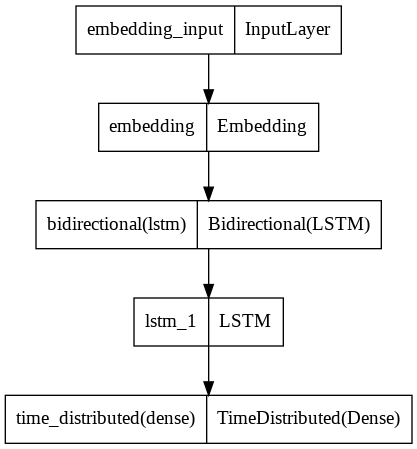

In [ ]:
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [ ]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 42s 1s/step - loss: 0.1035 - accuracy: 0.9697 - val_loss: 0.1169 - val_accuracy: 0.9697


#Train Accuracy - 96.97%

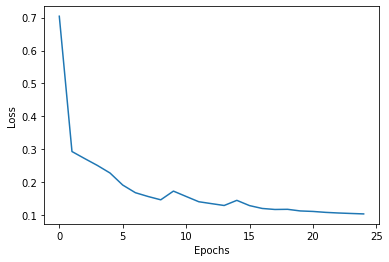

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

Testing


In [ ]:
#train_tokens, test_tokens, train_tags, test_tags
print("Evaluate model on test data")
results = model_bilstm_lstm.evaluate(test_tokens, np.array(test_tags))
print("test loss, test acc:", results)

Evaluate model on test data
150/150 [==============================] - 13s 83ms/step - loss: 0.1161 - accuracy: 0.9698
test loss, test acc: [0.11605168133974075, 0.969794511795044]


#Test accuracy - 96.97


Prediction

In [ ]:
test_tokens[:1]

array([[21366, 21388, 33124, 21376, 23833,  1256, 35039, 34162, 31386,
        21959, 21988, 12016, 21376, 15597, 30797,  8239,  7751,  3452,
        25465, 16317, 33573,   970, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
        35177, 35177, 35177, 35177, 35177]], dtype=int32)

In [ ]:
print("Generate a prediction")
prediction = model_bilstm_lstm.predict(test_tokens[:1])

Generate a prediction
1/1 [==============================] - 0s 111ms/step


In [ ]:
print("prediction shape:", prediction.shape)

prediction shape: (1, 104, 17)


In [ ]:
prediction

array([[[0.        , 0.        , 0.        , ..., 0.00321029,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.0133453 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.02581685,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

#SPACY EXPERIMENTATION

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

Example 1

In [ ]:
text = nlp('Mahendra Singh Dhoni , born 7 July 1981 is an Indian former international cricketer who was captain of the Indian national cricket team in limited-overs formats from 2007 to 2017 and in Test cricket from 2008 to 2014. He is also the current captain of CSK in the IPL. He led India to victory in three ICC trophies 2007 ICC World Twenty20, 2011 Cricket World Cup and 2013 ICC Champions Trophy, the most by any Indian captain. Under his captaincy India also won 2010 and 2016 Asia Cup. A right-handed wicket-keeper batsman. He scored over 10,000 runs in One Day Internationals, with the reputation as one of the best finishers in the game. He is also one of the greatest wicket-keepers in the history of cricket.')

In [ ]:
text

Mahendra Singh Dhoni , born 7 July 1981 is an Indian former international cricketer who was captain of the Indian national cricket team in limited-overs formats from 2007 to 2017 and in Test cricket from 2008 to 2014. He is also the current captain of CSK in the IPL. He led India to victory in three ICC trophies 2007 ICC World Twenty20, 2011 Cricket World Cup and 2013 ICC Champions Trophy, the most by any Indian captain. Under his captaincy India also won 2010 and 2016 Asia Cup. A right-handed wicket-keeper batsman. He scored over 10,000 runs in One Day Internationals, with the reputation as one of the best finishers in the game. He is also one of the greatest wicket-keepers in the history of cricket.

In [ ]:
for w in text.ents:
    print(w.text, w.label_)

Mahendra Singh Dhoni PERSON
7 July 1981 DATE
Indian NORP
Indian NORP
2007 DATE
2017 DATE
2008 DATE
2014 DATE
CSK ORG
IPL ORG
India GPE
three CARDINAL
2007 DATE
2011 DATE
2013 DATE
Indian NORP
India GPE
2010 DATE
2016 Asia Cup EVENT
over 10,000 CARDINAL
One CARDINAL


In [ ]:
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
spacy.explain('LANGUAGE')

'Any named language'

In [ ]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'

In [ ]:
spacy.explain('ORG')

'Companies, agencies, institutions, etc.'

In [ ]:
spacy.explain('GPE')

'Countries, cities, states'

Saving the model for further usage

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
# serialize model to JSON
model_json = model_bilstm_lstm.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_bilstm_lstm.save_weights("/content/drive/MyDrive/Colab Notebooks/model.h5")
print("Saved model to disk")

Saved model to disk
